# Neural Networks

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

t_u.shape

torch.Size([11, 1])

In [4]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 5,  0,  3,  7, 10,  8,  2,  6,  9]), tensor([1, 4]))

In [5]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

## Linear Model

In [6]:
linear_model = nn.Linear(1, 1)
linear_model(t_un_val)

tensor([[4.1145],
        [4.1387]], grad_fn=<AddmmBackward0>)

In [7]:
linear_model.weight

Parameter containing:
tensor([[0.6042]], requires_grad=True)

In [8]:
linear_model.bias

Parameter containing:
tensor([0.7369], requires_grad=True)

In [11]:
x = torch.ones(1)
linear_model(x)

tensor([1.3411], grad_fn=<ViewBackward0>)

In [12]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[1.3411],
        [1.3411],
        [1.3411],
        [1.3411],
        [1.3411],
        [1.3411],
        [1.3411],
        [1.3411],
        [1.3411],
        [1.3411]], grad_fn=<AddmmBackward0>)

In [15]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

In [21]:
linear_model.parameters()

<generator object Module.parameters at 0x7ae4311d4120>

In [22]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.7919]], requires_grad=True),
 Parameter containing:
 tensor([-0.3559], requires_grad=True)]

In [27]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch: {epoch}, Training loss: {loss_train.item():.4f}, Validation loss: {loss_val.item():.4f}")

In [29]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=linear_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch: 1, Training loss: 165.1709, Validation loss: 131.7801
Epoch: 1000, Training loss: 3.4634, Validation loss: 2.7266
Epoch: 2000, Training loss: 2.9853, Validation loss: 2.7311
Epoch: 3000, Training loss: 2.9778, Validation loss: 2.7318

Parameter containing:
tensor([[5.3758]], requires_grad=True)
Parameter containing:
tensor([-17.2738], requires_grad=True)


## Sequential Model

In [30]:
seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13,1)
)

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [33]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [35]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [37]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ("hidden_linear", nn.Linear(1, 8)),
    ("hidden_activation", nn.Tanh()),
    ("output_linear", nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [39]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [40]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.0130], requires_grad=True)

In [42]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val,
)

print("output", seq_model(t_un_val))
print("answer", t_c_val)
print("hidden", seq_model.hidden_linear.weight.grad)

Epoch: 1, Training loss: 1.6038, Validation loss: 3.9497
Epoch: 1000, Training loss: 1.5567, Validation loss: 2.8649
Epoch: 2000, Training loss: 1.5315, Validation loss: 2.9256
Epoch: 3000, Training loss: 1.5154, Validation loss: 2.9744
Epoch: 4000, Training loss: 1.5022, Validation loss: 3.0190
Epoch: 5000, Training loss: 1.4860, Validation loss: 3.0830
output tensor([[11.3487],
        [11.6184]], grad_fn=<AddmmBackward0>)
answer tensor([[14.],
        [11.]])
hidden tensor([[-4.8282],
        [ 0.1630],
        [-4.3242],
        [-0.1198],
        [-0.1392],
        [ 0.0806],
        [ 5.1660],
        [-4.6419]])


## Visualization

In [1]:
import matplotlib.pyplot as plt

In [44]:
t_range = torch.arange(20., 90.).unsqueeze(1)

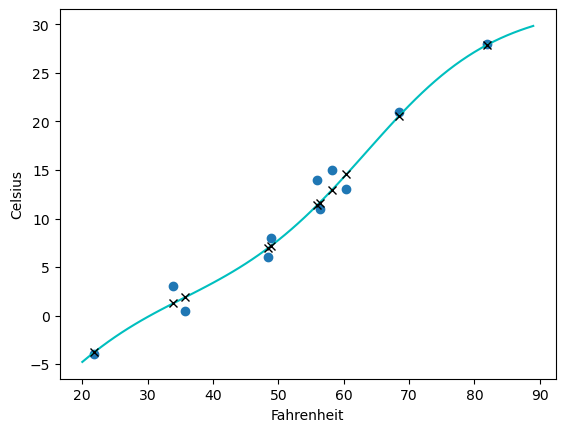

In [45]:
fig = plt.figure()
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), "o")
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), "c-")
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), "kx")
plt.show()

## Exercises

### Hidden Neurons

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
def train_val_split(X, y, val_ratio=0.2):
    n_samples = X.shape[0]
    n_val = int(val_ratio * n_samples)
    
    shuffled_indices = torch.randperm(n_samples)
    
    train_indices = shuffled_indices[:-n_val]
    val_indices = shuffled_indices[-n_val:]
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_val = X[val_indices]
    y_val = y[val_indices]

    return X_train, X_val, y_train, y_val

def get_normalized(X, scaling_factor=0.1):
    return scaling_factor * X

In [15]:
def visualize(X, y, model, savefig=False, figname=None):
    X_dummy = torch.arange(20., 90.).unsqueeze(1)
    
    fig = plt.figure()
    plt.xlabel("Fahrenheit")
    plt.ylabel("Celsius")
    plt.plot(X.numpy(), y.numpy(), "o")
    plt.plot(X_dummy.numpy(), model(get_normalized(X_dummy)).detach().numpy(), "c-")
    plt.plot(X.numpy(), model(get_normalized(X)).detach().numpy(), "kx")
    if savefig:
        plt.savefig(figname)
    plt.show()

In [4]:
def train(n_epochs, model, optimizer, loss_fn, X_train, X_val, y_train, y_val):
    for epoch in range(1, n_epochs + 1):
        y_pred_train = model(X_train)
        training_loss = loss_fn(y_pred_train, y_train)

        y_pred_val = model(X_val)
        validation_loss = loss_fn(y_pred_val, y_val)

        optimizer.zero_grad()
        training_loss.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch: {epoch}, Training loss: {training_loss.item():.4f}, Validation loss: {validation_loss.item():.4f}")

In [5]:
X = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
y = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]

X = torch.tensor(X).unsqueeze(1)
y = torch.tensor(y).unsqueeze(1)

X_train, X_val, y_train, y_val = train_val_split(X, y, val_ratio=0.2)

X_train_normalized = get_normalized(X_train, scaling_factor=0.1)
X_val_normalized = get_normalized(X_val, scaling_factor=0.1)

In [16]:
def experiment(hidden_neurons, learning_rate, savefig=False, figname=None):
    print(f"Hidden neurons: {hidden_neurons}, Learning rate: {learning_rate}")
    model = nn.Sequential(
        nn.Linear(1, hidden_neurons),
        nn.Tanh(),
        nn.Linear(hidden_neurons, 1),
    )

    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    train(
        n_epochs=5000,
        model=model,
        optimizer=optimizer,
        loss_fn=nn.MSELoss(),
        X_train=X_train_normalized,
        X_val=X_val_normalized,
        y_train=y_train,
        y_val=y_val,
    )

    visualize(X, y, model, savefig, figname)

Hidden neurons: 1, Learning rate: 0.001
Epoch: 1, Training loss: 204.5242, Validation loss: 204.5155
Epoch: 1000, Training loss: 23.6263, Validation loss: 1.9062
Epoch: 2000, Training loss: 20.9194, Validation loss: 22.7708
Epoch: 3000, Training loss: 16.6897, Validation loss: 31.0530
Epoch: 4000, Training loss: 13.8356, Validation loss: 33.3884
Epoch: 5000, Training loss: 13.1747, Validation loss: 35.3701


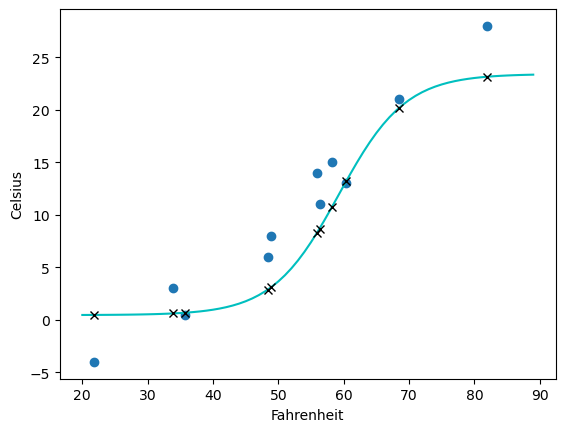

Hidden neurons: 1, Learning rate: 0.0001
Epoch: 1, Training loss: 196.2460, Validation loss: 193.1095
Epoch: 1000, Training loss: 138.7008, Validation loss: 110.8887
Epoch: 2000, Training loss: 112.7632, Validation loss: 68.4096
Epoch: 3000, Training loss: 101.0498, Validation loss: 45.6403
Epoch: 4000, Training loss: 95.6101, Validation loss: 32.9138
Epoch: 5000, Training loss: 88.4199, Validation loss: 28.0582


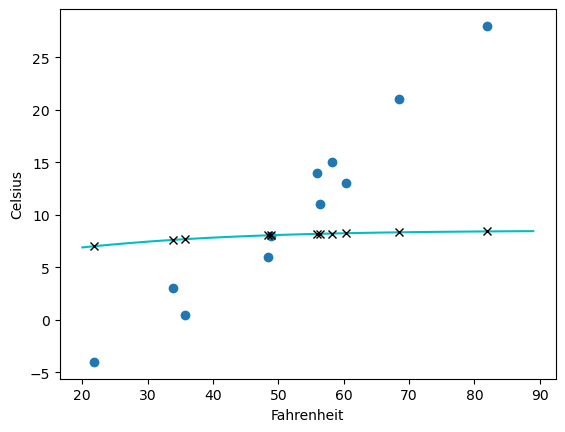

Hidden neurons: 2, Learning rate: 0.001
Epoch: 1, Training loss: 178.0755, Validation loss: 168.5918
Epoch: 1000, Training loss: 14.2766, Validation loss: 2.2809
Epoch: 2000, Training loss: 4.7010, Validation loss: 5.2137
Epoch: 3000, Training loss: 2.0168, Validation loss: 5.8225
Epoch: 4000, Training loss: 2.4666, Validation loss: 7.1599
Epoch: 5000, Training loss: 1.9466, Validation loss: 6.6079


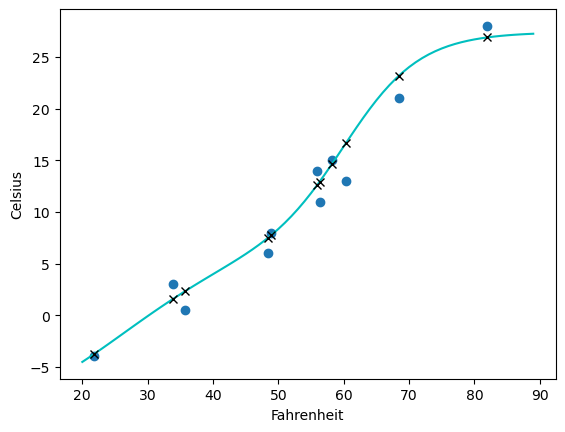

Hidden neurons: 2, Learning rate: 0.0001
Epoch: 1, Training loss: 200.5127, Validation loss: 198.7163
Epoch: 1000, Training loss: 120.8425, Validation loss: 88.1129
Epoch: 2000, Training loss: 86.0567, Validation loss: 44.6380
Epoch: 3000, Training loss: 63.5842, Validation loss: 23.8116
Epoch: 4000, Training loss: 47.0354, Validation loss: 12.0343
Epoch: 5000, Training loss: 35.8323, Validation loss: 5.7103


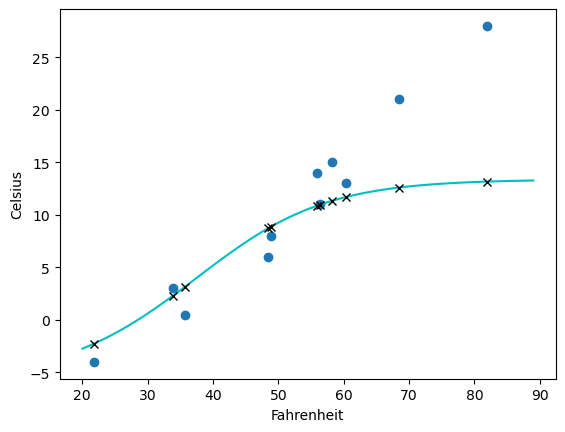

Hidden neurons: 3, Learning rate: 0.001
Epoch: 1, Training loss: 180.6086, Validation loss: 171.6111
Epoch: 1000, Training loss: 10.1920, Validation loss: 3.1471
Epoch: 2000, Training loss: 3.2686, Validation loss: 4.6399
Epoch: 3000, Training loss: 1.7343, Validation loss: 5.1236
Epoch: 4000, Training loss: 1.4431, Validation loss: 5.0758
Epoch: 5000, Training loss: 1.5939, Validation loss: 5.2419


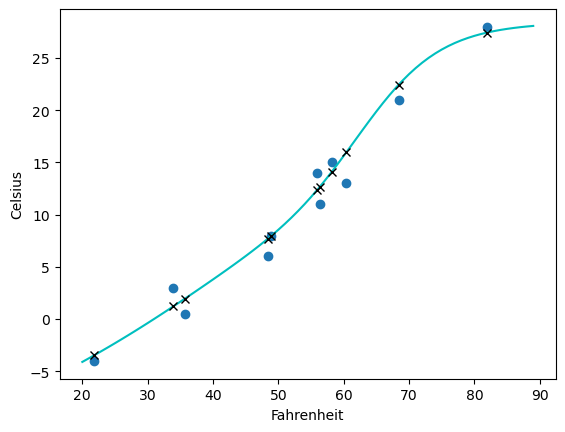

Hidden neurons: 3, Learning rate: 0.0001
Epoch: 1, Training loss: 173.3581, Validation loss: 161.7107
Epoch: 1000, Training loss: 105.0508, Validation loss: 59.2958
Epoch: 2000, Training loss: 81.6255, Validation loss: 30.6922
Epoch: 3000, Training loss: 62.6608, Validation loss: 17.3622
Epoch: 4000, Training loss: 45.3364, Validation loss: 9.1747
Epoch: 5000, Training loss: 32.7462, Validation loss: 4.4082


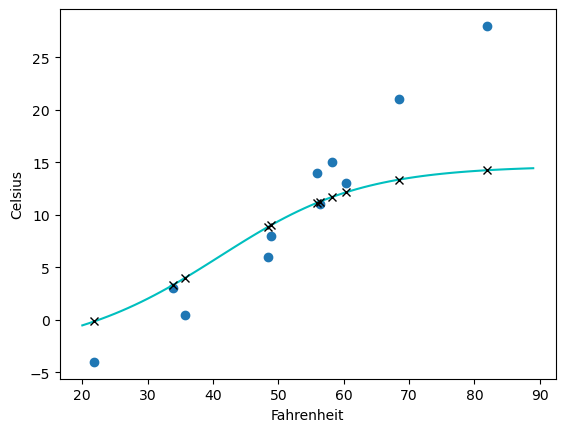

Hidden neurons: 4, Learning rate: 0.001
Epoch: 1, Training loss: 184.5375, Validation loss: 177.4265
Epoch: 1000, Training loss: 8.5577, Validation loss: 3.0474
Epoch: 2000, Training loss: 3.2004, Validation loss: 7.6017
Epoch: 3000, Training loss: 1.6144, Validation loss: 5.8333
Epoch: 4000, Training loss: 1.3515, Validation loss: 5.6584
Epoch: 5000, Training loss: 1.3174, Validation loss: 5.6756


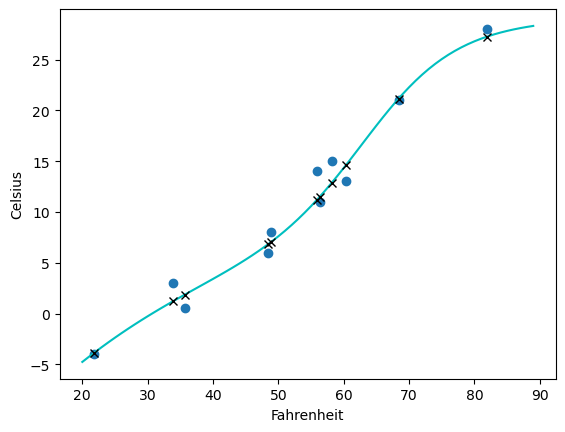

Hidden neurons: 4, Learning rate: 0.0001
Epoch: 1, Training loss: 170.9790, Validation loss: 157.9492
Epoch: 1000, Training loss: 88.9703, Validation loss: 43.8981
Epoch: 2000, Training loss: 61.5746, Validation loss: 18.7147
Epoch: 3000, Training loss: 42.2856, Validation loss: 8.2345
Epoch: 4000, Training loss: 28.9324, Validation loss: 3.4396
Epoch: 5000, Training loss: 20.8746, Validation loss: 1.8678


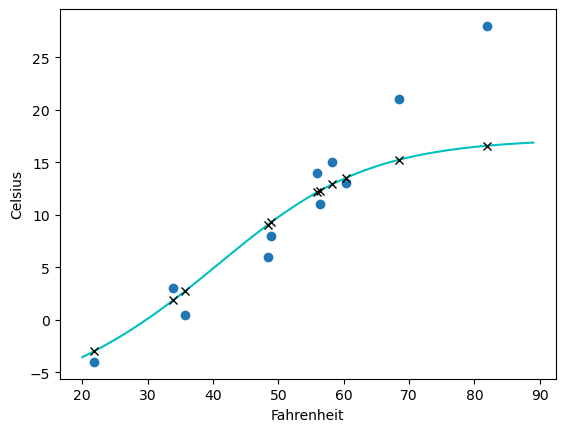

Hidden neurons: 5, Learning rate: 0.001
Epoch: 1, Training loss: 176.7704, Validation loss: 166.4277
Epoch: 1000, Training loss: 6.5298, Validation loss: 3.6964
Epoch: 2000, Training loss: 2.5634, Validation loss: 7.3305
Epoch: 3000, Training loss: 1.3680, Validation loss: 5.1480
Epoch: 4000, Training loss: 1.3996, Validation loss: 5.8027
Epoch: 5000, Training loss: 1.3848, Validation loss: 5.7930


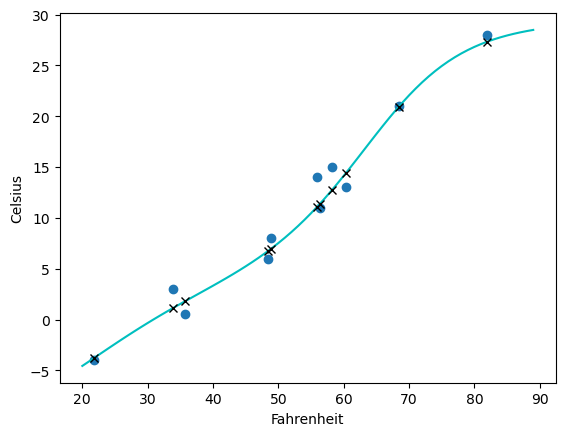

Hidden neurons: 5, Learning rate: 0.0001
Epoch: 1, Training loss: 192.4381, Validation loss: 187.5902
Epoch: 1000, Training loss: 87.0984, Validation loss: 40.4009
Epoch: 2000, Training loss: 58.9522, Validation loss: 15.7072
Epoch: 3000, Training loss: 39.3349, Validation loss: 6.4785
Epoch: 4000, Training loss: 25.8802, Validation loss: 2.6664
Epoch: 5000, Training loss: 18.0716, Validation loss: 1.7320


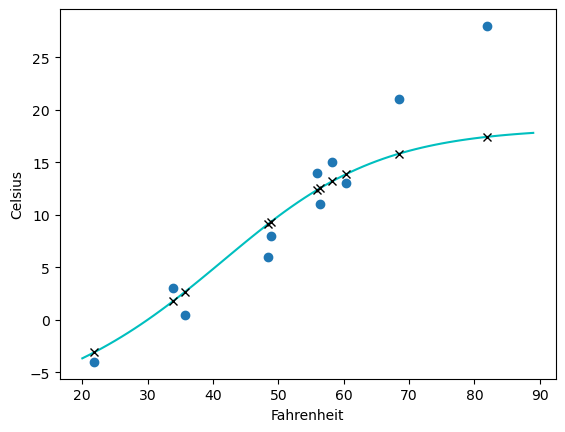

Hidden neurons: 6, Learning rate: 0.001
Epoch: 1, Training loss: 176.3111, Validation loss: 167.5663
Epoch: 1000, Training loss: 5.4078, Validation loss: 3.7572
Epoch: 2000, Training loss: 2.6639, Validation loss: 5.0075
Epoch: 3000, Training loss: 1.4042, Validation loss: 4.9636
Epoch: 4000, Training loss: 1.2190, Validation loss: 4.9875
Epoch: 5000, Training loss: 1.2229, Validation loss: 5.0419


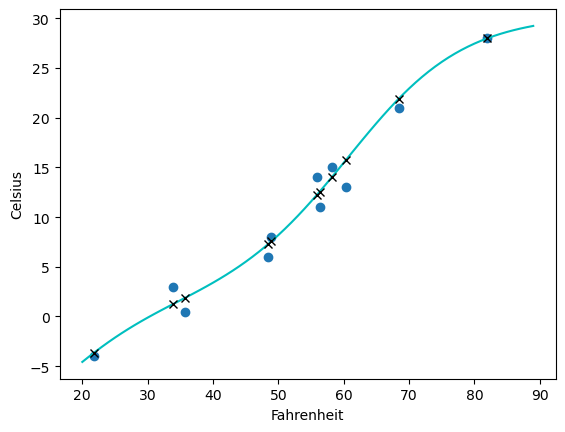

Hidden neurons: 6, Learning rate: 0.0001
Epoch: 1, Training loss: 180.4681, Validation loss: 171.7135
Epoch: 1000, Training loss: 77.9762, Validation loss: 31.0846
Epoch: 2000, Training loss: 51.1447, Validation loss: 11.2885
Epoch: 3000, Training loss: 32.9204, Validation loss: 4.3164
Epoch: 4000, Training loss: 21.3809, Validation loss: 1.9850
Epoch: 5000, Training loss: 15.0004, Validation loss: 1.8143


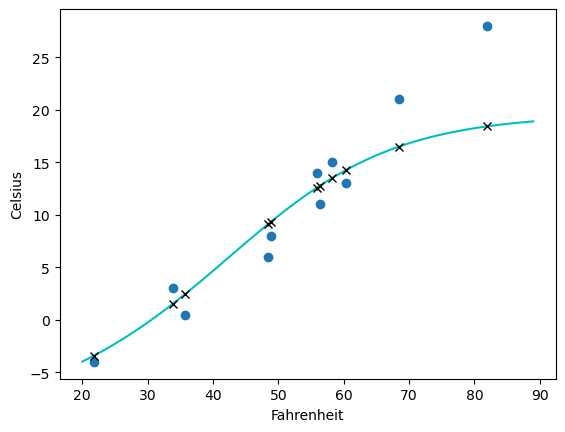

Hidden neurons: 7, Learning rate: 0.001
Epoch: 1, Training loss: 208.7932, Validation loss: 209.1058
Epoch: 1000, Training loss: 4.9480, Validation loss: 3.9446
Epoch: 2000, Training loss: 2.8762, Validation loss: 8.6513
Epoch: 3000, Training loss: 1.4724, Validation loss: 5.7860
Epoch: 4000, Training loss: 1.3351, Validation loss: 5.5231
Epoch: 5000, Training loss: 1.3120, Validation loss: 5.5238


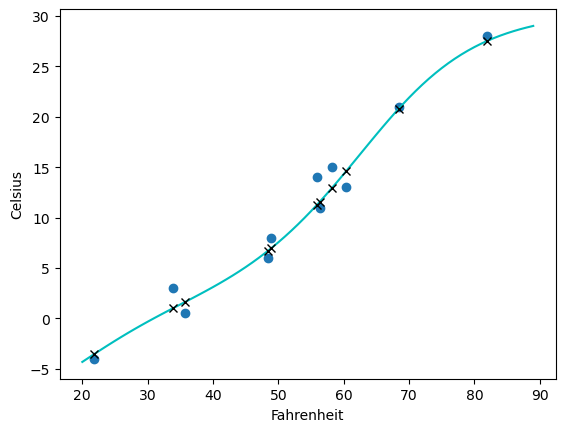

Hidden neurons: 7, Learning rate: 0.0001
Epoch: 1, Training loss: 182.0934, Validation loss: 174.8926
Epoch: 1000, Training loss: 75.2579, Validation loss: 27.7618
Epoch: 2000, Training loss: 46.8862, Validation loss: 8.8599
Epoch: 3000, Training loss: 28.3346, Validation loss: 3.1697
Epoch: 4000, Training loss: 18.3310, Validation loss: 1.7675
Epoch: 5000, Training loss: 12.9350, Validation loss: 2.0217


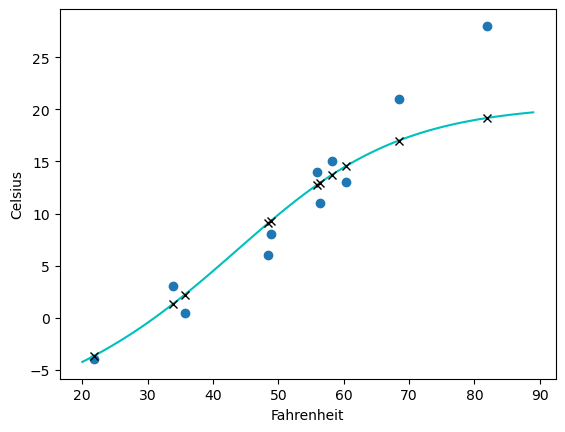

Hidden neurons: 8, Learning rate: 0.001
Epoch: 1, Training loss: 178.1660, Validation loss: 168.3094
Epoch: 1000, Training loss: 4.2773, Validation loss: 3.9374
Epoch: 2000, Training loss: 1.6396, Validation loss: 5.2694
Epoch: 3000, Training loss: 1.3814, Validation loss: 5.2451
Epoch: 4000, Training loss: 1.2769, Validation loss: 5.0236
Epoch: 5000, Training loss: 1.2640, Validation loss: 5.0778


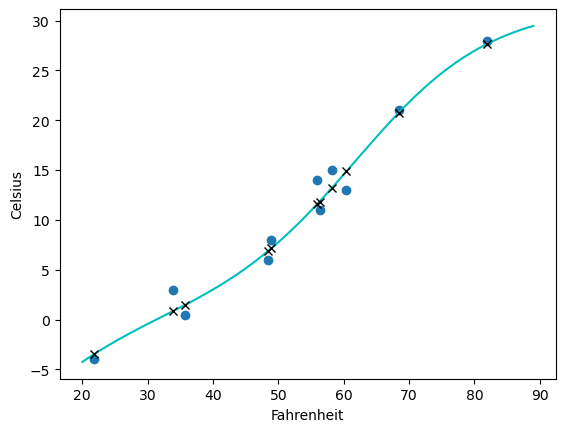

Hidden neurons: 8, Learning rate: 0.0001
Epoch: 1, Training loss: 194.3951, Validation loss: 191.2385
Epoch: 1000, Training loss: 80.5819, Validation loss: 26.0436
Epoch: 2000, Training loss: 52.1784, Validation loss: 9.9516
Epoch: 3000, Training loss: 32.4805, Validation loss: 3.8757
Epoch: 4000, Training loss: 20.1642, Validation loss: 1.8677
Epoch: 5000, Training loss: 13.4830, Validation loss: 1.8974


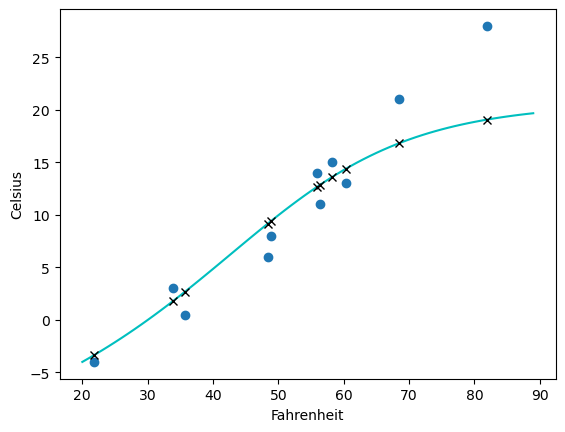

Hidden neurons: 9, Learning rate: 0.001
Epoch: 1, Training loss: 186.4509, Validation loss: 179.9683
Epoch: 1000, Training loss: 3.8305, Validation loss: 3.9893
Epoch: 2000, Training loss: 3.1946, Validation loss: 9.4719
Epoch: 3000, Training loss: 1.4133, Validation loss: 5.3467
Epoch: 4000, Training loss: 1.3223, Validation loss: 5.1766
Epoch: 5000, Training loss: 1.3028, Validation loss: 5.2210


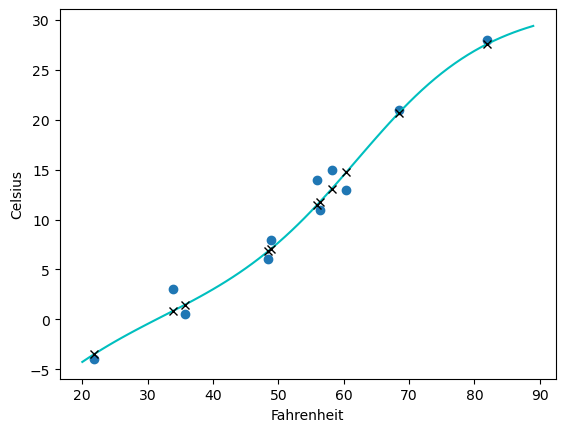

Hidden neurons: 9, Learning rate: 0.0001
Epoch: 1, Training loss: 182.7757, Validation loss: 174.3952
Epoch: 1000, Training loss: 73.4417, Validation loss: 22.0530
Epoch: 2000, Training loss: 45.7745, Validation loss: 7.1496
Epoch: 3000, Training loss: 27.3673, Validation loss: 2.6362
Epoch: 4000, Training loss: 16.6510, Validation loss: 1.7910
Epoch: 5000, Training loss: 11.1332, Validation loss: 2.2468


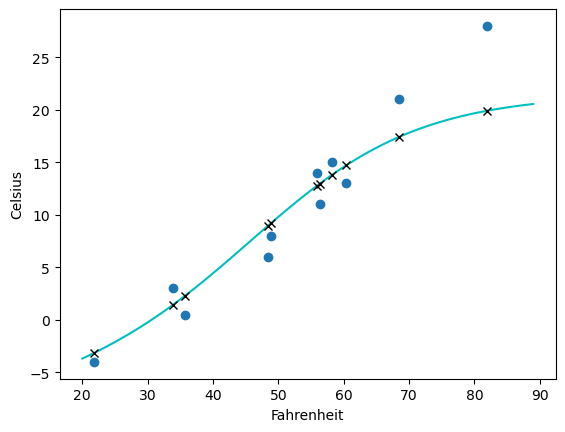

Hidden neurons: 10, Learning rate: 0.001
Epoch: 1, Training loss: 165.4782, Validation loss: 150.7898
Epoch: 1000, Training loss: 4.0273, Validation loss: 3.8914
Epoch: 2000, Training loss: 1.5831, Validation loss: 4.4525
Epoch: 3000, Training loss: 1.4390, Validation loss: 5.1074
Epoch: 4000, Training loss: 1.2982, Validation loss: 4.7478
Epoch: 5000, Training loss: 1.2658, Validation loss: 4.7182


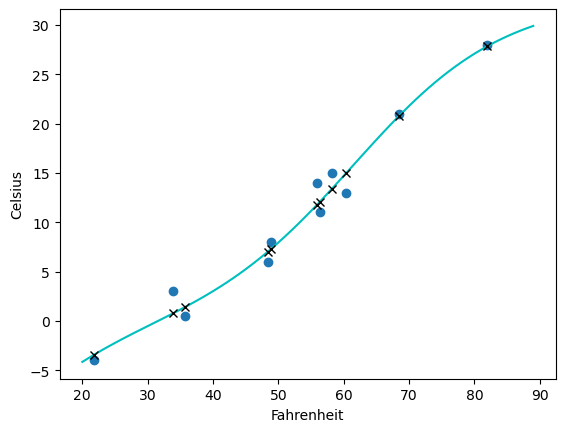

Hidden neurons: 10, Learning rate: 0.0001
Epoch: 1, Training loss: 182.9086, Validation loss: 174.4411
Epoch: 1000, Training loss: 77.0134, Validation loss: 19.5339
Epoch: 2000, Training loss: 47.3914, Validation loss: 7.7655
Epoch: 3000, Training loss: 28.5003, Validation loss: 2.7875
Epoch: 4000, Training loss: 16.8879, Validation loss: 1.7204
Epoch: 5000, Training loss: 11.1385, Validation loss: 2.1531


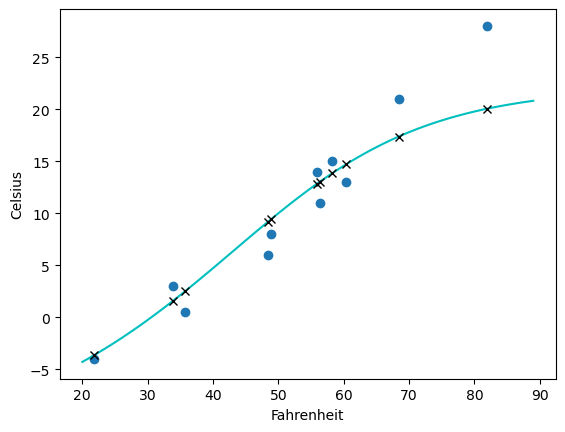

Hidden neurons: 11, Learning rate: 0.001
Epoch: 1, Training loss: 188.6107, Validation loss: 182.3665
Epoch: 1000, Training loss: 3.6552, Validation loss: 3.8917
Epoch: 2000, Training loss: 1.5435, Validation loss: 4.2922
Epoch: 3000, Training loss: 1.2860, Validation loss: 4.4459
Epoch: 4000, Training loss: 1.2384, Validation loss: 4.5335
Epoch: 5000, Training loss: 1.2102, Validation loss: 4.6164


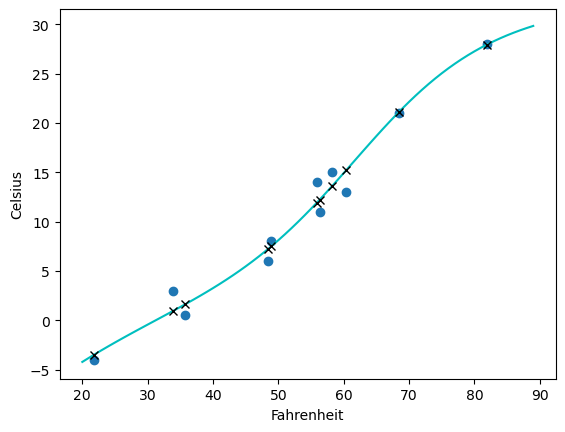

Hidden neurons: 11, Learning rate: 0.0001
Epoch: 1, Training loss: 177.1805, Validation loss: 166.7027
Epoch: 1000, Training loss: 77.2525, Validation loss: 18.3221
Epoch: 2000, Training loss: 60.7248, Validation loss: 8.4508
Epoch: 3000, Training loss: 42.3471, Validation loss: 4.3952
Epoch: 4000, Training loss: 26.2614, Validation loss: 2.2579
Epoch: 5000, Training loss: 15.8447, Validation loss: 1.8468


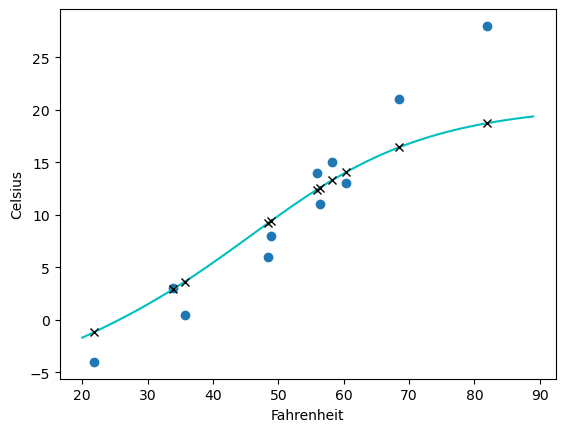

Hidden neurons: 12, Learning rate: 0.001
Epoch: 1, Training loss: 181.8198, Validation loss: 174.1244
Epoch: 1000, Training loss: 3.8057, Validation loss: 4.0261
Epoch: 2000, Training loss: 2.6956, Validation loss: 4.2329
Epoch: 3000, Training loss: 1.7976, Validation loss: 4.3661
Epoch: 4000, Training loss: 1.4059, Validation loss: 4.4140
Epoch: 5000, Training loss: 1.3083, Validation loss: 4.4491


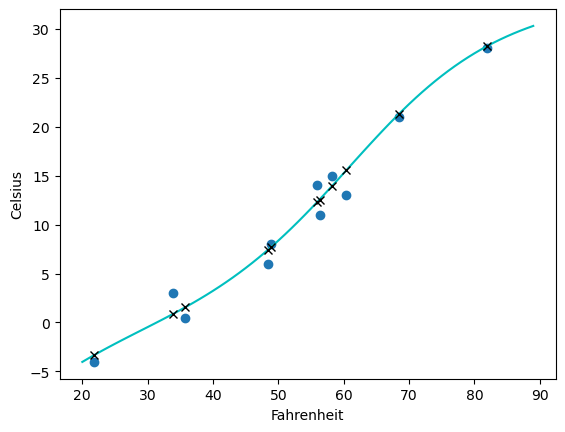

Hidden neurons: 12, Learning rate: 0.0001
Epoch: 1, Training loss: 179.3151, Validation loss: 167.5592
Epoch: 1000, Training loss: 79.6145, Validation loss: 17.7366
Epoch: 2000, Training loss: 60.5501, Validation loss: 8.3278
Epoch: 3000, Training loss: 42.1280, Validation loss: 4.2083
Epoch: 4000, Training loss: 25.6240, Validation loss: 2.1915
Epoch: 5000, Training loss: 15.4220, Validation loss: 1.8610


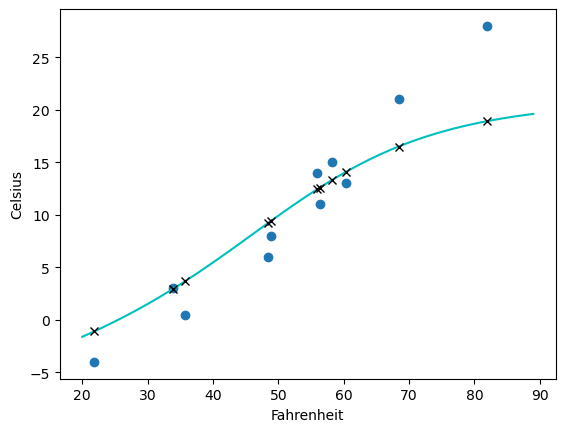

Hidden neurons: 13, Learning rate: 0.001
Epoch: 1, Training loss: 182.4917, Validation loss: 174.0583
Epoch: 1000, Training loss: 3.5819, Validation loss: 3.9537
Epoch: 2000, Training loss: 1.6326, Validation loss: 4.2156
Epoch: 3000, Training loss: 1.6013, Validation loss: 4.2889
Epoch: 4000, Training loss: 1.4186, Validation loss: 4.4011
Epoch: 5000, Training loss: 1.2930, Validation loss: 4.4374


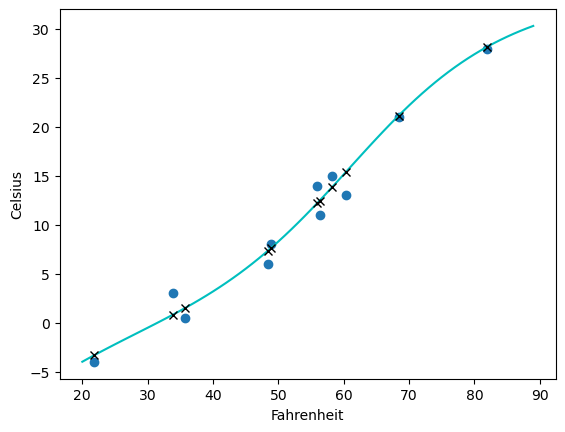

Hidden neurons: 13, Learning rate: 0.0001
Epoch: 1, Training loss: 179.3713, Validation loss: 170.2746
Epoch: 1000, Training loss: 83.5231, Validation loss: 16.2993
Epoch: 2000, Training loss: 69.9026, Validation loss: 9.4616
Epoch: 3000, Training loss: 52.8050, Validation loss: 5.7795
Epoch: 4000, Training loss: 34.7504, Validation loss: 2.9774
Epoch: 5000, Training loss: 19.9819, Validation loss: 1.8115


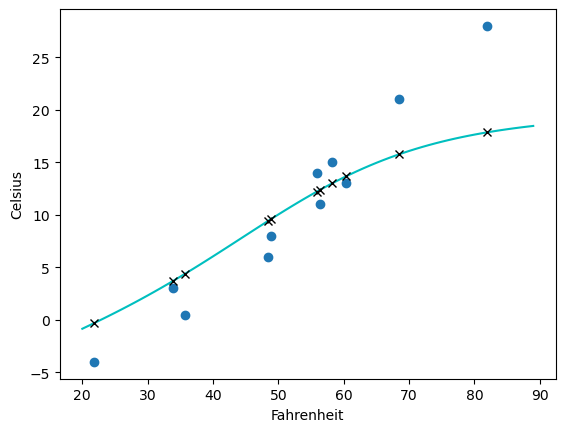

Hidden neurons: 14, Learning rate: 0.001
Epoch: 1, Training loss: 177.9817, Validation loss: 168.8031
Epoch: 1000, Training loss: 3.5892, Validation loss: 3.8783
Epoch: 2000, Training loss: 1.6609, Validation loss: 4.1145
Epoch: 3000, Training loss: 1.6405, Validation loss: 4.2364
Epoch: 4000, Training loss: 1.4304, Validation loss: 4.3177
Epoch: 5000, Training loss: 1.2986, Validation loss: 4.3772


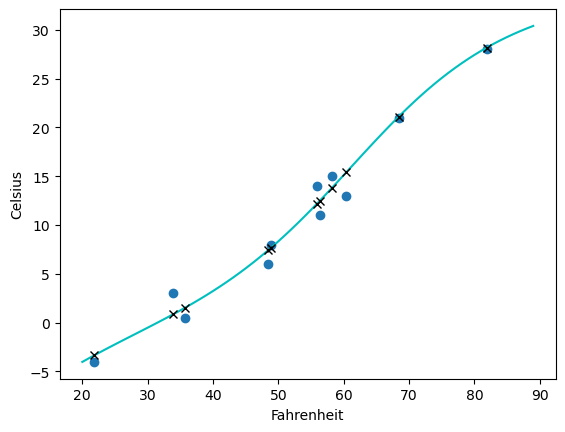

Hidden neurons: 14, Learning rate: 0.0001
Epoch: 1, Training loss: 188.6273, Validation loss: 182.1863
Epoch: 1000, Training loss: 72.7468, Validation loss: 13.7128
Epoch: 2000, Training loss: 51.8031, Validation loss: 5.8859
Epoch: 3000, Training loss: 33.6489, Validation loss: 2.7586
Epoch: 4000, Training loss: 19.2531, Validation loss: 1.8339
Epoch: 5000, Training loss: 11.4131, Validation loss: 2.1788


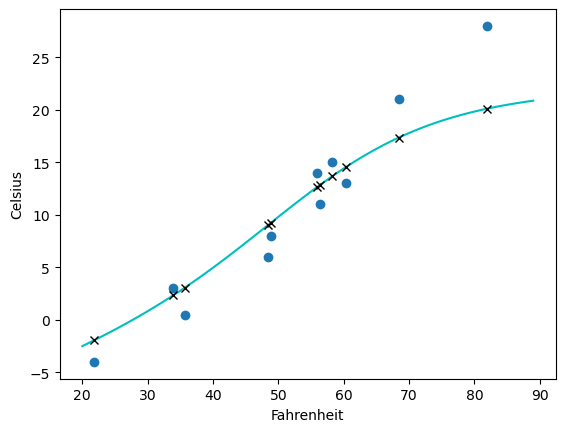

Hidden neurons: 15, Learning rate: 0.001
Epoch: 1, Training loss: 203.1017, Validation loss: 202.0060
Epoch: 1000, Training loss: 2.6537, Validation loss: 4.2769
Epoch: 2000, Training loss: 1.4549, Validation loss: 4.5151
Epoch: 3000, Training loss: 1.3489, Validation loss: 4.5510
Epoch: 4000, Training loss: 1.3137, Validation loss: 4.5547
Epoch: 5000, Training loss: 1.2856, Validation loss: 4.5638


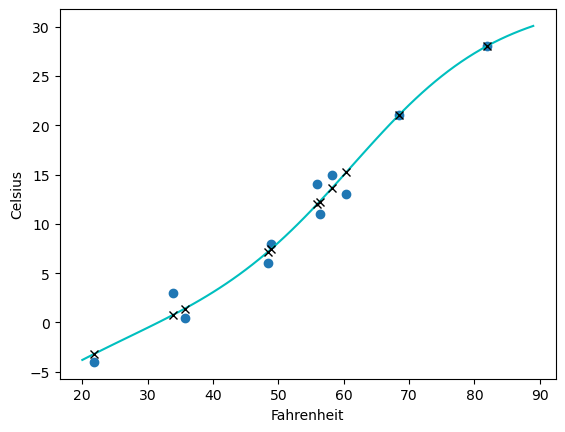

Hidden neurons: 15, Learning rate: 0.0001
Epoch: 1, Training loss: 199.7622, Validation loss: 198.6358
Epoch: 1000, Training loss: 68.3289, Validation loss: 12.5615
Epoch: 2000, Training loss: 38.6445, Validation loss: 4.5904
Epoch: 3000, Training loss: 21.5169, Validation loss: 1.8391
Epoch: 4000, Training loss: 12.4320, Validation loss: 1.8850
Epoch: 5000, Training loss: 8.3933, Validation loss: 2.6174


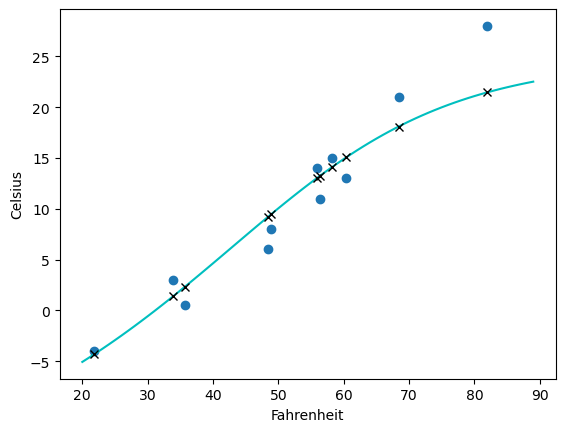

Hidden neurons: 16, Learning rate: 0.001
Epoch: 1, Training loss: 191.0182, Validation loss: 186.5009
Epoch: 1000, Training loss: 2.9757, Validation loss: 3.9422
Epoch: 2000, Training loss: 1.5549, Validation loss: 4.1020
Epoch: 3000, Training loss: 1.3413, Validation loss: 4.2449
Epoch: 4000, Training loss: 1.3002, Validation loss: 4.3348
Epoch: 5000, Training loss: 1.2786, Validation loss: 4.3835


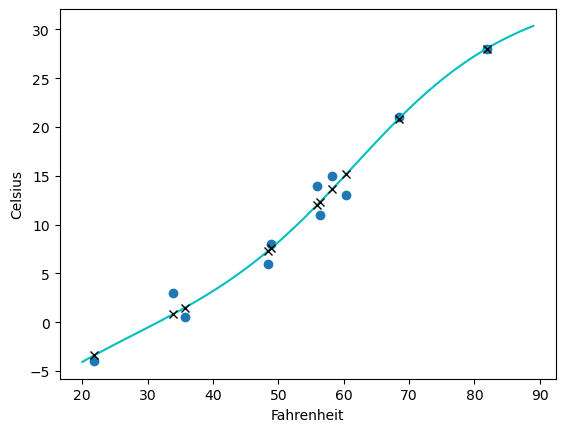

Hidden neurons: 16, Learning rate: 0.0001
Epoch: 1, Training loss: 176.1500, Validation loss: 166.0423
Epoch: 1000, Training loss: 71.6820, Validation loss: 12.3635
Epoch: 2000, Training loss: 53.6174, Validation loss: 5.6223
Epoch: 3000, Training loss: 32.9725, Validation loss: 2.7336
Epoch: 4000, Training loss: 18.6195, Validation loss: 1.7065
Epoch: 5000, Training loss: 10.8003, Validation loss: 2.1324


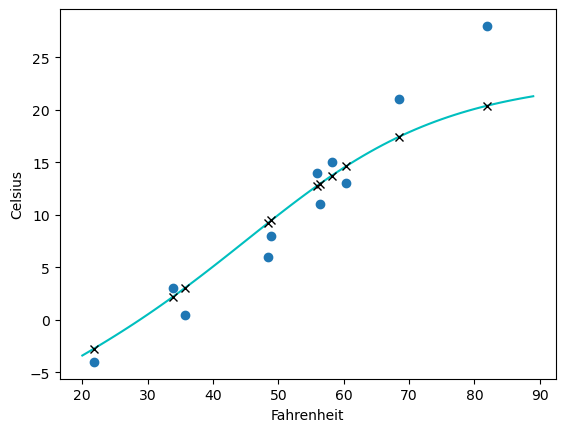

Hidden neurons: 17, Learning rate: 0.001
Epoch: 1, Training loss: 170.5011, Validation loss: 157.5638
Epoch: 1000, Training loss: 2.7083, Validation loss: 4.0483
Epoch: 2000, Training loss: 1.4813, Validation loss: 4.2013
Epoch: 3000, Training loss: 1.3383, Validation loss: 4.3020
Epoch: 4000, Training loss: 1.3038, Validation loss: 4.3745
Epoch: 5000, Training loss: 1.2801, Validation loss: 4.4336


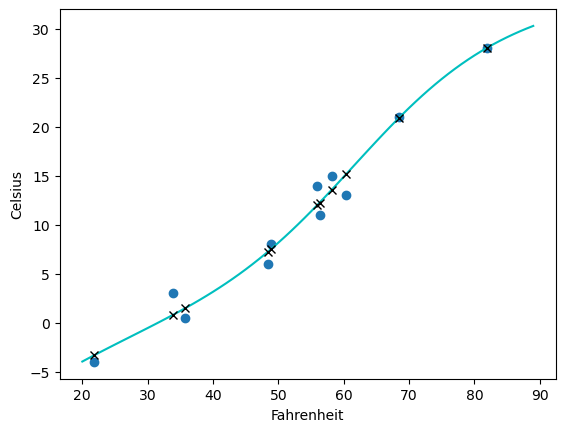

Hidden neurons: 17, Learning rate: 0.0001
Epoch: 1, Training loss: 177.1207, Validation loss: 168.3146
Epoch: 1000, Training loss: 56.7120, Validation loss: 9.3155
Epoch: 2000, Training loss: 31.2080, Validation loss: 2.7508
Epoch: 3000, Training loss: 16.6819, Validation loss: 1.6589
Epoch: 4000, Training loss: 10.0302, Validation loss: 2.2082
Epoch: 5000, Training loss: 7.1786, Validation loss: 2.9422


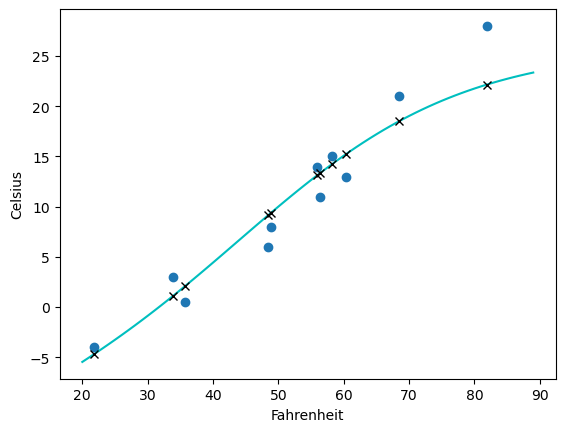

Hidden neurons: 18, Learning rate: 0.001
Epoch: 1, Training loss: 187.3437, Validation loss: 180.7566
Epoch: 1000, Training loss: 2.8949, Validation loss: 3.9561
Epoch: 2000, Training loss: 1.5347, Validation loss: 4.1059
Epoch: 3000, Training loss: 1.3579, Validation loss: 4.2160
Epoch: 4000, Training loss: 1.3173, Validation loss: 4.2861
Epoch: 5000, Training loss: 1.2925, Validation loss: 4.3425


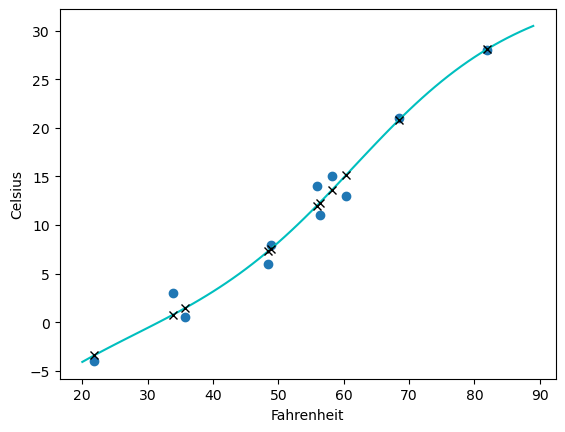

Hidden neurons: 18, Learning rate: 0.0001
Epoch: 1, Training loss: 200.3113, Validation loss: 198.2837
Epoch: 1000, Training loss: 57.7834, Validation loss: 9.3085
Epoch: 2000, Training loss: 32.8341, Validation loss: 2.7014
Epoch: 3000, Training loss: 16.6270, Validation loss: 1.6048
Epoch: 4000, Training loss: 9.8274, Validation loss: 2.2891
Epoch: 5000, Training loss: 7.4339, Validation loss: 3.0278


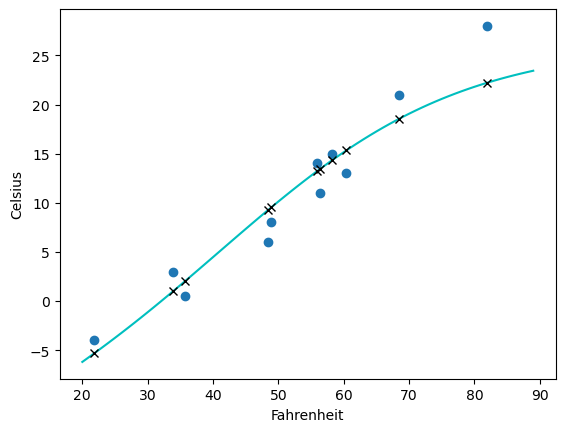

Hidden neurons: 19, Learning rate: 0.001
Epoch: 1, Training loss: 191.5772, Validation loss: 187.9069
Epoch: 1000, Training loss: 2.6839, Validation loss: 3.9964
Epoch: 2000, Training loss: 1.4897, Validation loss: 4.1501
Epoch: 3000, Training loss: 1.3423, Validation loss: 4.2646
Epoch: 4000, Training loss: 1.3064, Validation loss: 4.3527
Epoch: 5000, Training loss: 1.2845, Validation loss: 4.4118


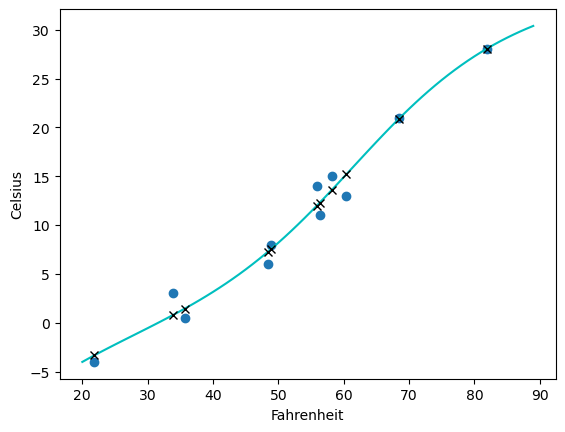

Hidden neurons: 19, Learning rate: 0.0001
Epoch: 1, Training loss: 184.3804, Validation loss: 176.9651
Epoch: 1000, Training loss: 55.6741, Validation loss: 8.2055
Epoch: 2000, Training loss: 32.2446, Validation loss: 2.6222
Epoch: 3000, Training loss: 17.2289, Validation loss: 1.6532
Epoch: 4000, Training loss: 9.7322, Validation loss: 2.2575
Epoch: 5000, Training loss: 6.7383, Validation loss: 2.9914


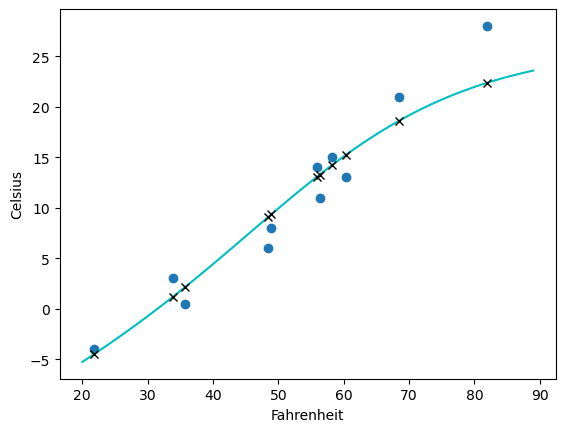

Hidden neurons: 20, Learning rate: 0.001
Epoch: 1, Training loss: 201.1443, Validation loss: 200.1129
Epoch: 1000, Training loss: 3.1917, Validation loss: 3.9151
Epoch: 2000, Training loss: 1.8016, Validation loss: 3.9098
Epoch: 3000, Training loss: 1.4906, Validation loss: 3.9866
Epoch: 4000, Training loss: 1.4245, Validation loss: 4.0498
Epoch: 5000, Training loss: 1.4019, Validation loss: 4.0955


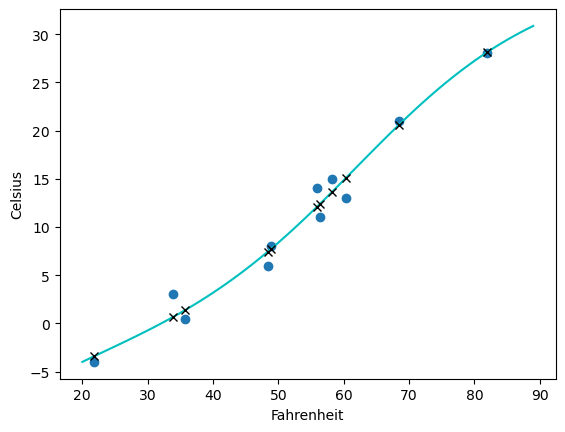

Hidden neurons: 20, Learning rate: 0.0001
Epoch: 1, Training loss: 188.2751, Validation loss: 182.5913
Epoch: 1000, Training loss: 68.2300, Validation loss: 10.1442
Epoch: 2000, Training loss: 44.8565, Validation loss: 4.4836
Epoch: 3000, Training loss: 26.2118, Validation loss: 2.0066
Epoch: 4000, Training loss: 14.3727, Validation loss: 1.7546
Epoch: 5000, Training loss: 8.6416, Validation loss: 2.4298


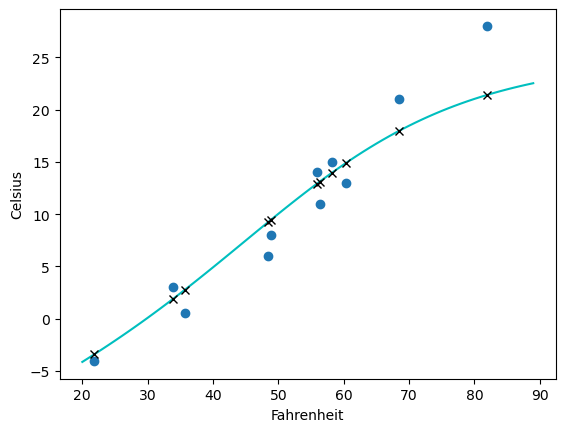

In [8]:
for i in range(1, 21):
    for j in [1e-3, 1e-4]:
        experiment(hidden_neurons=i, learning_rate=j)

Hidden neurons: 1, Learning rate: 1e-05
Epoch: 1, Training loss: 190.4148, Validation loss: 185.1680
Epoch: 1000, Training loss: 182.8119, Validation loss: 174.7266
Epoch: 2000, Training loss: 175.7764, Validation loss: 164.9639
Epoch: 3000, Training loss: 169.2724, Validation loss: 155.8427
Epoch: 4000, Training loss: 163.2593, Validation loss: 147.3180
Epoch: 5000, Training loss: 157.6994, Validation loss: 139.3484


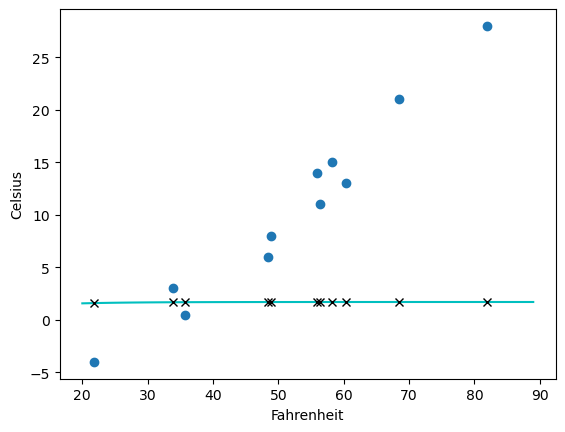

In [17]:
experiment(hidden_neurons=1, learning_rate=1e-5, savefig=True, figname="data/linear-model.png")

Hidden neurons: 20, Learning rate: 0.001
Epoch: 1, Training loss: 186.3171, Validation loss: 180.2154
Epoch: 1000, Training loss: 3.8941, Validation loss: 3.8063
Epoch: 2000, Training loss: 2.0927, Validation loss: 3.8224
Epoch: 3000, Training loss: 1.7978, Validation loss: 3.7291
Epoch: 4000, Training loss: 1.5289, Validation loss: 3.8752
Epoch: 5000, Training loss: 1.4141, Validation loss: 4.0108


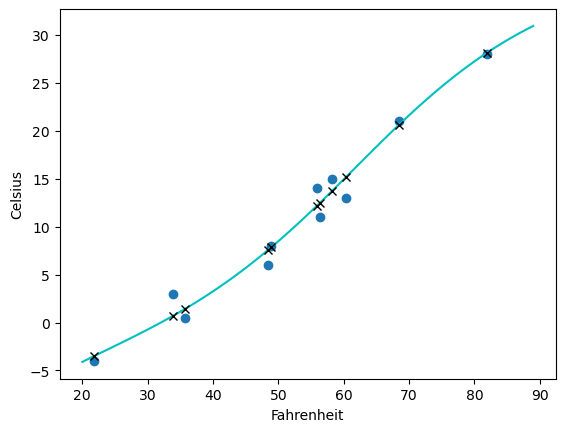

In [18]:
experiment(hidden_neurons=20, learning_rate=1e-3, savefig=True, figname="data/overfitted-model.png")

### Wine Dataset

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
wine_df = pd.read_csv("data/wine.csv", delimiter=";")
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
X = wine_df.drop("quality", axis=1).values
y = wine_df["quality"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [4]:
in_features = 11
hidden_features = 64
out_features = 11

model = nn.Sequential(
    nn.Linear(in_features, hidden_features),
    nn.ReLU(),
    nn.Linear(hidden_features, hidden_features),
    nn.ReLU(),
    nn.Linear(hidden_features, out_features),
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [5]:
def train(n_epochs, model, criterion, optimizer, train_loader):
    losses = []
    start_time = time.time()
    
    for epoch in tqdm(range(n_epochs)):
        running_loss = 0.0
    
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.shape[0]

        epoch_loss = running_loss / len(train_loader.dataset)
        losses.append(epoch_loss)

    training_time = time.time() - start_time    
    return losses, training_time

In [6]:
losses, training_time = train(
    n_epochs=1000,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
)

100%|██████████| 1000/1000 [04:20<00:00,  3.84it/s]


In [33]:
def evaluate(model, test_loader):
    n = 0
    correct = 0
    running_loss = 0
    
    model.eval()
    loss_fn = nn.L1Loss()
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            n += targets.shape[0]
            correct += (predicted == targets).sum().item()
            
            loss = loss_fn(predicted.to(torch.float32), targets.to(torch.float32))
            running_loss += loss.item() * targets.shape[0]
    
    accuracy = (correct / n) * 100
    average_error = running_loss / n
    
    return accuracy, average_error

In [34]:
accuracy, average_error = evaluate(model, test_loader)
print(f"Accuracy: {accuracy:.2f}%, Average error: {average_error:.2f}")

Accuracy: 61.22%, Average error: 0.47


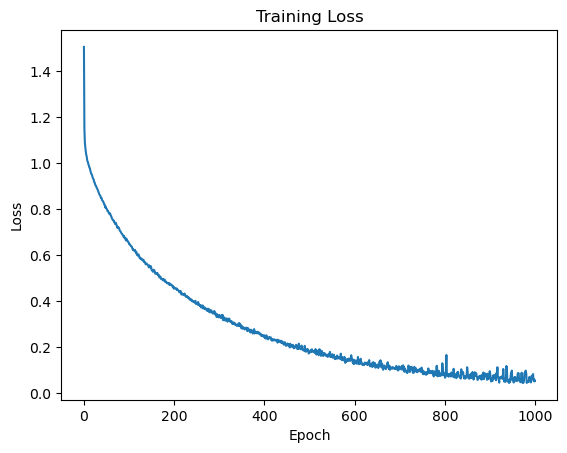

In [11]:
epochs = list(range(len(losses)))
plt.plot(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.savefig("data/training-loss.png")
plt.show()

In [10]:
print(f"Training time: {training_time:.4f} sec")

Training time: 260.2706 sec


### Dataset Visualization

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
wine_df = pd.read_csv("data/wine.csv", delimiter=";")
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


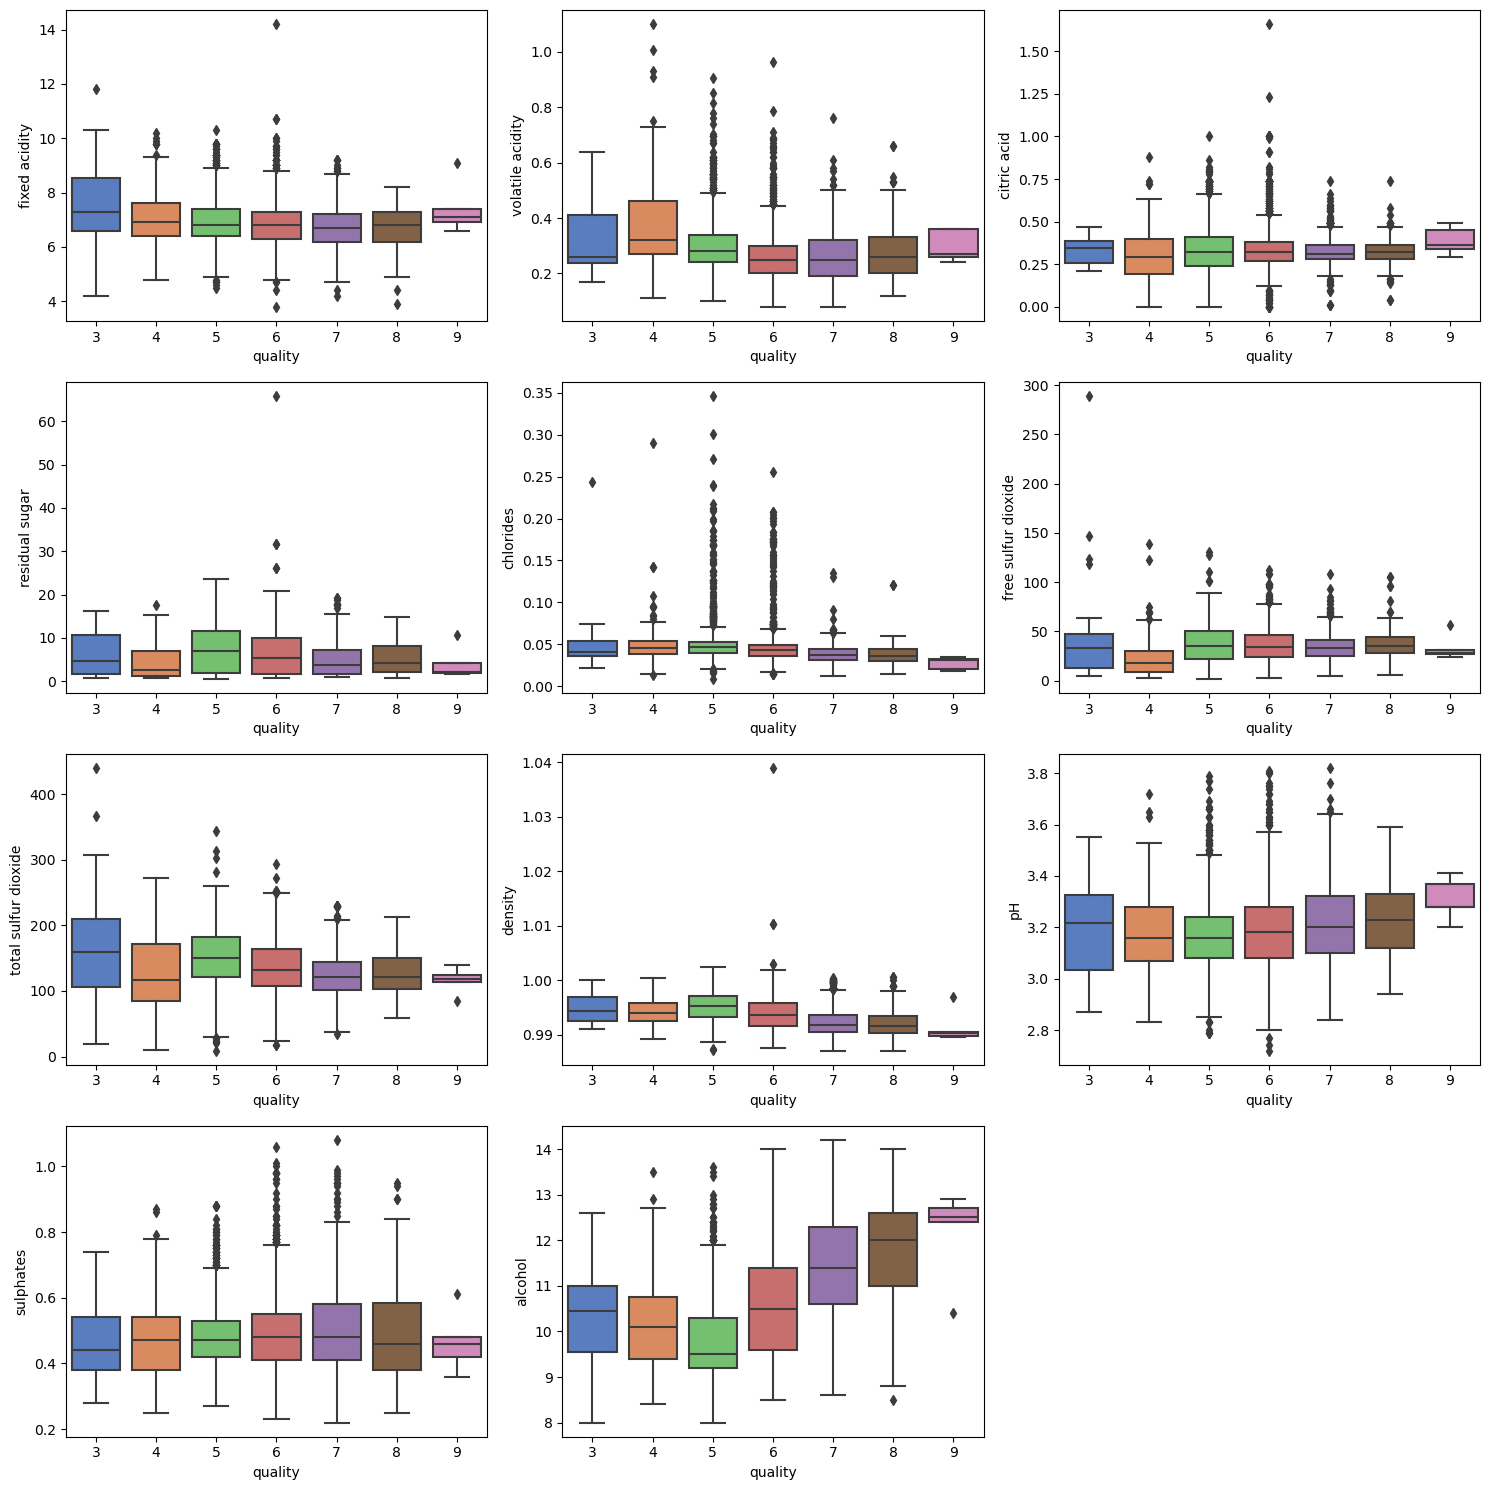

In [71]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
sns.boxplot(data=wine_df, x="quality", y="fixed acidity", palette="muted", ax=axs[0, 0])
sns.boxplot(data=wine_df, x="quality", y="volatile acidity", palette="muted", ax=axs[0, 1])
sns.boxplot(data=wine_df, x="quality", y="citric acid", palette="muted", ax=axs[0, 2])
sns.boxplot(data=wine_df, x="quality", y="residual sugar", palette="muted", ax=axs[1, 0])
sns.boxplot(data=wine_df, x="quality", y="chlorides", palette="muted", ax=axs[1, 1])
sns.boxplot(data=wine_df, x="quality", y="free sulfur dioxide", palette="muted", ax=axs[1, 2])
sns.boxplot(data=wine_df, x="quality", y="total sulfur dioxide", palette="muted", ax=axs[2, 0])
sns.boxplot(data=wine_df, x="quality", y="density", palette="muted", ax=axs[2, 1])
sns.boxplot(data=wine_df, x="quality", y="pH", palette="muted", ax=axs[2, 2])
sns.boxplot(data=wine_df, x="quality", y="sulphates", palette="muted", ax=axs[3, 0])
sns.boxplot(data=wine_df, x="quality", y="alcohol", palette="muted", ax=axs[3, 1])

axs[3, 2].axis("off")
fig.tight_layout()
plt.savefig("data/wine-boxplots.png")
plt.show()

### Model Visualization

In [91]:
def get_predictions(model, test_loader):
    errors = torch.empty((0))
    model.eval()

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            error = (predicted - targets)
            errors = torch.cat((errors, error), dim=0)
    
    return errors

In [97]:
errors = get_predictions(model, test_loader)

errors_df = pd.DataFrame({
    "Error": errors,
})

errors_df.head()

,Error
0,-1.0
1,1.0
2,-1.0
3,0.0
4,1.0


/home/akaabdullahmateen/miniforge3/envs/gpu/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


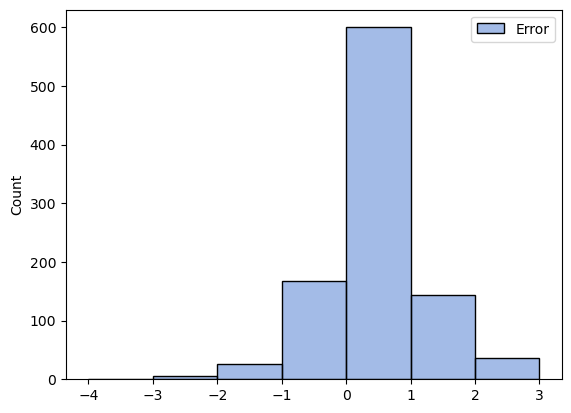

In [100]:
sns.histplot(errors_df, palette="muted", binwidth=1)
plt.savefig("data/prediction-errors.png")
plt.show()